In [2]:
# setup django

import os
import sys
sys.path.append('../../')
os.environ["DJANGO_SETTINGS_MODULE"] = "settings"
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "settings")
import django
django.setup()

In [3]:
# imports

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import Birch, DBSCAN, KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt

from apps.document.models import Document

In [4]:
# method is one of: Birch, KMeans, MiniBatchKMeans

def get_cluster_data(documents=Document.objects.all(),
                     n_clusters=3,
                     method='KMeans'):

    if method not in ['Birch', 'KMeans', 'MiniBatchKMeans']:
        method = 'KMeans'

    # Get dococuments' data
    docs = np.array(documents.values_list('pk', 'name', 'full_text'))
    ids, names, data = docs[:, 0], docs[:, 1], docs[:, 2]

    # Turning a collection of text documents into numerical feature vectors.
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=100,
                                 min_df=2, stop_words='english',
                                 use_idf=True)
    X = vectorizer.fit_transform(data)
    terms = vectorizer.get_feature_names()

    # Build Cluster model
    if method == 'MiniBatchKMeans':
        m = MiniBatchKMeans(
            n_clusters=n_clusters,
            init='k-means++',
            n_init=1,
            init_size=100,
            batch_size=100,
            verbose=False)
    elif method == 'KMeans':
        m = KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            max_iter=100,
            n_init=1,
            verbose=False)
    elif method == 'Birch':
        m = Birch(
            n_clusters=n_clusters,
            threshold=0.5,
            branching_factor=50)
    m.fit(X)

    # transform vectorized documents data into 2D
    _X = X.toarray()
    pca = PCA(n_components=2).fit(_X)
    data2D = pca.transform(_X)

    # extract cluster centers
    if method == 'Birch':
        cluster_centers = m.subcluster_centers_
    else:    
        cluster_centers = m.cluster_centers_

    order_centroids = cluster_centers.argsort()[:, ::-1]
    # get cluster labels (0, 1, 2...) and claster terms (mpst common tags)
    clusters = m.labels_.tolist()
    cluster_ids = set(clusters)
    cluster_num = len(cluster_ids)
    cluster_terms = [[terms[ind] for ind in order_centroids[i, :5]] for i in range(n_clusters)]

    # get 2D cluster centers 
    centers2D = pca.transform(cluster_centers)

    # build result data
    cluster_data = []
    for cluster_id in cluster_ids:
        a_cluster = {
            'cluster_id': cluster_id,
            'cluster_terms': cluster_terms[cluster_id],
            'cluster_name': '-'.join(cluster_terms[cluster_id]),
            'centroid_coord': centers2D[cluster_id].tolist() if centers2D is not None else None,
            'document_data': [
                {'document_id': int(ids[n]),
                 'document_name': names[n],
                 'coord': data2D[n].tolist()} for n, i in enumerate(clusters) if i == cluster_id]
        }
        cluster_data.append(a_cluster)

    return cluster_data

In [5]:
def print_cluster_data(cluster_data):
    for cl in cluster_data:
        print('='*50)
        print('Cluster#%d: %s' % (cl['cluster_id'], cl['cluster_name']))
        print('-'*50)
        for doc in cl['document_data']:
            print('  id=%d, %s' % (doc['document_id'], doc['document_name']))

In [6]:
def plot(cluster_data):
    cluster_num = len(cluster_data)
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'pink', 'brown', 'orange', 'teal', 'coral', 'lightblue', 'lime', 'lavender', 'turquoise', 'darkgreen', 'tan', 'salmon', 'gold', 'lightpurple', 'darkred', 'darkblue']
    # set chart size
    plt.figure(figsize=(12,6))    
    # plot clusters
    for n, cl in enumerate(cluster_data):
        x = [i['coord'][0] for i in cl['document_data']]
        y = [i['coord'][1] for i in cl['document_data']]
        #color = plt.cm.get_cmap('hsv', max(10, cluster_num))(n)
        color = colors[n]
        label = 'Cluster#%d: %s' % (cl['cluster_id'], cl['cluster_name'])
        plt.scatter(x, y, c=color, s=150, label=label)
        plt.legend()
    # plot centers
    centers_x = [i['centroid_coord'][0] for i in cluster_data]
    centers_y = [i['centroid_coord'][1] for i in cluster_data]
    plt.scatter(centers_x, centers_y, marker='x', s=100, linewidths=1, c='k')
    plt.show() 

/home/alex/dev/michael/contraxsuite/ve/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


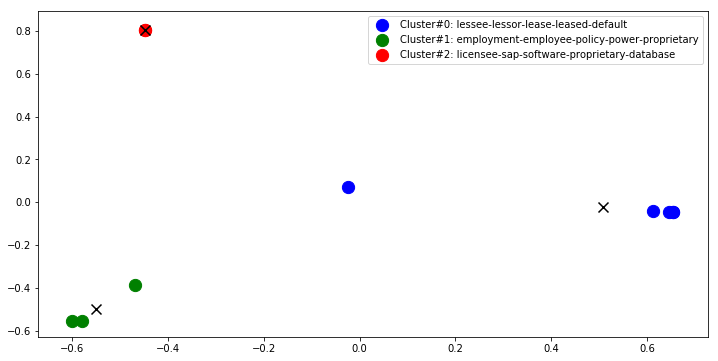

In [7]:
# method is one of: Birch, KMeans, MiniBatchKMeans

cluster_data = get_cluster_data(n_clusters=3, method='KMeans')
#cluster_data = get_cluster_data(Document.objects.filter(project_id=27), n_clusters=4, method='MiniBatchKMeans')

plot(cluster_data)

#print_cluster_data(cluster_data)